<a href="https://colab.research.google.com/github/TakuInada/umcuEpi_longterm_ieeg_respect_bids/blob/master/tensorpac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tensorpec

In [ ]:
!pip install tensorpac
!pip install matplotlib==3.9.1
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'axes.spines.top': False, 'axes.spines.right': False})

import warnings
warnings.filterwarnings("ignore")

#import numpy as np
#import matplotlib.pyplot as plt
#plt.rcParams.update({'axes.spines.top': False, 'axes.spines.right': False})

from tensorpac import Pac
from tensorpac.utils import PSD
from tensorpac.signals import pac_signals_tort

Reason for being yanked: The Windows wheels, under some conditions, caused segfaults in unrelated user code.  Due to this we deleted the Windows wheels to prevent these segfaults, however this caused greater disruption as pip then began to try (and fail) to build 3.9.1 from the sdist on Windows which impacted far more users.  Yanking the whole release is the only tool available to eliminate these failures without changes to on the user side.  The sdist, OSX wheel, and manylinux wheels are all functional and there are no critical bugs in the release.   Downstream packagers should not yank their builds of Matplotlib 3.9.1.  See https://github.com/matplotlib/matplotlib/issues/28551 for details.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 53.2 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.8.1
    Uninstalling matplotlib-3.8.1:
      Successfully uninstalled matplotlib-3.8.1


In [ ]:
# Dataset of signals artificially coupled between 10hz and 100hz :
n_epochs = 20    # number of trials
sf = 512.        # sampling frequency
T = 0.5          # one trials time (sec)
n_times = sf * T # number of time points

In [ ]:
# Create artificially coupled signals using Tort method :
data, time = pac_signals_tort(f_pha=10, f_amp=100, noise=2, n_epochs=n_epochs,
                              dpha=10, damp=10, sf=sf, n_times=n_times)
print("data shape (n_epochs, n_times): ", data.shape)

data shape (n_epochs, n_times):  (20, 256)


Phase Amplitude Coupling object defined
INFO:tensorpac:Phase Amplitude Coupling object defined
    extract phases (n_pha=50) and amplitudes (n_amps=50)
INFO:tensorpac:    extract phases (n_pha=50) and amplitudes (n_amps=50)
    true PAC estimation using Gaussian Copula PAC (gcPac)
INFO:tensorpac:    true PAC estimation using Gaussian Copula PAC (gcPac)


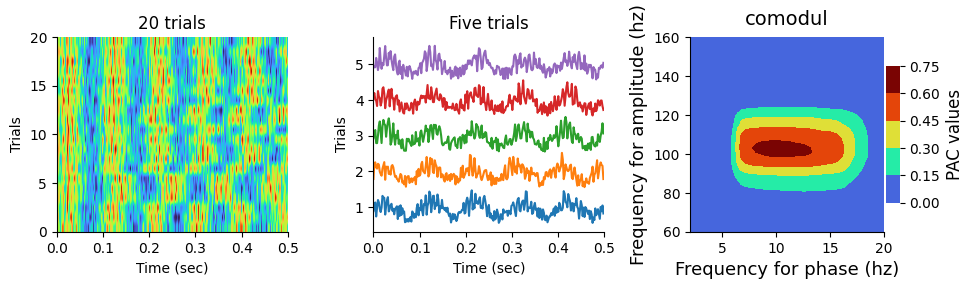

In [ ]:
plt.figure(figsize=(10, 3))
plt.subplot(1,3,1)
plt.title(str(n_epochs)+" trials")
plt.imshow(data, cmap="turbo", extent=(0,T,0,n_epochs), aspect='auto')
plt.xlim(0, T); plt.xlabel("Time (sec)"); plt.ylabel("Trials")
plt.subplot(1,3,2)
plt.title("Five trials")
for i in range(5):
    plt.plot(time, data[i]*0.2+i+0.75)
plt.xlim(0, T); plt.xlabel("Time (sec)"); plt.ylabel("Trials")
plt.subplot(1,3,3)
# Define a Pac object
p = Pac(idpac=(6, 0, 0), f_pha='hres', f_amp='hres')
# Fileter the data and extract pac
xpac = p.filterfit(sf, data)
# Plot your PAC
p.comodulogram(xpac.mean(-1), cmap="turbo", plotas = 'contour', ncontours=5,
               title="comodul", fz_title=14, fz_labels=13)
plt.tight_layout()

Power Spectral Density estimation

Compute PSD over 20 trials and 256 time points
INFO:tensorpac:Compute PSD over 20 trials and 256 time points
    Add 95th confidence interval
INFO:tensorpac:    Add 95th confidence interval


TypeError: LogScale.__init__() got an unexpected keyword argument 'basex'

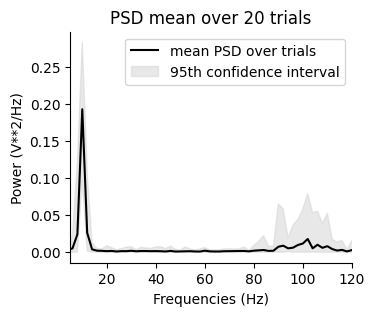

In [ ]:
psd = PSD(data, sf)

plt.figure(figsize=(8, 3))
plt.subplot(1,2,1)
# The 'basex' argument is deprecated
psd.plot(confidence=95, f_min=5, f_max=120, log=True, grid=True, fz_title=12, fz_labels=10)
plt.subplot(1,2,2)
psd.plot_st_psd(f_min=5, f_max=120, log=True, grid=True, fz_title=12, fz_labels=10, fz_cblabel=10)
plt.tight_layout()

Only first plot was depicted because of using 'basex' which is not supported in the plt.xscale function any more.